## Background

We have heard of [embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) in relation to Large Language Models (LLMs).  LLMs are built on very very large (millions to billion+) [tokens](https://arxiv.org/pdf/2203.15556.pdf) in a large (hundreds to few thousands) dimensional space. 

Below we build a simple DeepLearning model with <b>2-D embeddings and visualize them</b>.


## Model

Below code is built based on the tutorial by Andrej Karpathy. Highly recommend his Deep Learning [playlist](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), take time to listen, understand, and work through the code, make changes, fail and succeed.

Approach is based on Multi-Layer Perceptron (MLP) [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bengio et al. (2003). 
Instead of using words(tokens) to build sentences as in the paper, characters(tokens) are used to build names. Model has no hidden layer. Hidden layers can be added by changing the variable <i>hlayers = N</i>.

Model has a total of 27 tokens, 26 lower case alphabets and a start/stop character. Tokens are embedded in a 2 dimensional vector space and stored as a tensor C internally in the model.

Goal is a build a model to guess names.

In [1]:
import string

import numpy as np
import copy
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# Download datafile from makemore github repo
#url="https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
#words = requests.get(url,timeout=5).text.splitlines()

#OR if the file is downloaded locally
words = open("./data/names.txt",'r').read().splitlines()
print(f"Total number of words: {len(words)}")

Total number of words: 32033


In [3]:
# Build a MLP model, reduced representation, https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

#Block size (Sequence length)
blk_sz = 4

stoi = {x:i for i, x in enumerate(list(string.ascii_lowercase), 1)}
# Represents word beginning or ending
stoi['.'] = 0
itos = {i:x for x,i in stoi.items()}

def build_ngram(words):
    X = []
    Y = []
    for i, w in enumerate(words):
        context = [0]*blk_sz
        for c in f"{w}.":
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', c)
            context = context[1:] + [ix]
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y, dtype=torch.long)

# Split the data into training, dev/validation, test set
trn_d, tst_d = train_test_split(words, test_size=0.2)
val_d, tst_d = train_test_split(tst_d, test_size=0.5)
print(len(trn_d), len(tst_d), len(val_d))

trn_d, trn_l = build_ngram(trn_d)
tst_d, tst_l = build_ngram(tst_d)
val_d, val_l = build_ngram(val_d)
print(trn_d.shape, tst_d.shape, val_d.shape, trn_l.shape, tst_l.shape, val_l.shape)

# create dataloader objects
batch_size = 64
dl_trn = DataLoader(TensorDataset(trn_d, trn_l), shuffle=True, batch_size=batch_size, drop_last=True)
dl_val = DataLoader(TensorDataset(val_d, val_l), batch_size=len(val_l))

25626 3204 3203
torch.Size([182513, 4]) torch.Size([22916, 4]) torch.Size([22717, 4]) torch.Size([182513]) torch.Size([22916]) torch.Size([22717])


In [4]:
class DLmodel(nn.Module):
    def __init__(self, nunits, nlayers, indim, outdim):
        super().__init__()
        
        self.nlayers = nlayers
        self.layers = nn.ModuleDict()
        self.layers['input'] = nn.Linear(indim, nunits, bias=False)
        self.layers[f"bnorm-inp"] = nn.BatchNorm1d(nunits, momentum=0.001)
        self.layers[f"nl-inp"] = nn.Tanh()
        for i in range(nlayers):
            self.layers[f"hidden-{i}"] = nn.Linear(nunits, nunits, bias=False)
            self.layers[f"bnorm-{i}"] = nn.BatchNorm1d(nunits, momentum=0.001)
            self.layers[f"nl-{i}"] = nn.Tanh()
        self.layers['output'] = nn.Linear(nunits, outdim)


    # forward prop
    def forward(self, data):
        x = self.layers["input"](data)
        x = self.layers[f"bnorm-inp"](x)
        x = self.layers[f"nl-inp"](x)
        for i in range(self.nlayers):
            x = self.layers[f"hidden-{i}"](x)
            x = self.layers[f"bnorm-{i}"](x)
            x = self.layers[f"nl-{i}"](x)
        x = self.layers["output"](x)
        return x


In [5]:
# Create the model

#embedding size
emb_sz = 5

out_sz = 27
units = 100
hlayers = 0

# units in hidden layers, number of hidden layers, input size, output size
mdl = DLmodel(units, hlayers, emb_sz*blk_sz, out_sz)
summary(mdl)
print(mdl)

Layer (type:depth-idx)                   Param #
├─ModuleDict: 1-1                        --
|    └─Linear: 2-1                       2,000
|    └─BatchNorm1d: 2-2                  200
|    └─Tanh: 2-3                         --
|    └─Linear: 2-4                       2,727
Total params: 4,927
Trainable params: 4,927
Non-trainable params: 0
DLmodel(
  (layers): ModuleDict(
    (input): Linear(in_features=20, out_features=100, bias=False)
    (bnorm-inp): BatchNorm1d(100, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (nl-inp): Tanh()
    (output): Linear(in_features=100, out_features=27, bias=True)
  )
)


In [6]:
# Create the 2 dimensional feature vector C, easier to visualize the token embeddings 
sd = torch.Generator().manual_seed(42)
C = torch.randn((out_sz, emb_sz), generator=sd)
Cinit = copy.deepcopy(C)
C.requires_grad = True

In [7]:
def mdltrn(mdl, trn_data, val_data, lossfn, optimizer='SGD', epochs=100, lr=0.01):
    #pytorch automatically attaches the sigmoid to the output layer inside the loss function
    #i.e. F.CrossEntropyLoss = F.log_softmax(F.nll_loss)
    optm = getattr(torch.optim, optimizer)([C] + list(mdl.parameters()), lr=lr)

    trnloss = np.zeros(epochs)
    tstloss = np.zeros(epochs)
    for i in range(epochs):
        batchloss = []
        for X, y in trn_data:
            emb = C[X]           
            yH = mdl(emb.view(-1, blk_sz*emb_sz))
            loss = lossfn(yH, y)

            #backprop
            optm.zero_grad()
            loss.backward()
            optm.step()

            batchloss.append(loss.item())

        trnloss[i] = np.mean(batchloss)
        
        # Epoch Test Loss
        X, y = next(iter(val_data))
        mdl.eval()
        with torch.no_grad():
            emb = C[X]
            yH = mdl(emb.view(-1, blk_sz*emb_sz))
        tstloss[i] = lossfn(yH, y)
        mdl.train()
    return trnloss, tstloss

In [8]:
# Using SGD with manual learning rate decay
# Recommendeded to use Adam optimizer because of faster convergence (less epochs), 
# and doesn't require setting learning rate decay. 
optm = 'SGD'
lossfn = nn.CrossEntropyLoss()

# List of number of epochs and learning rate
lr_e = [(10, .1)]*10
lr_e[-2] = (10, .05)
lr_e[-1] = (10, .01)

trnloss = []
valloss = []
for i, item in enumerate(lr_e, 1):
    trnlossi, vallossi  = mdltrn(mdl, dl_trn, dl_val, lossfn, optm, item[0], item[1])
    print(f"{i*item[0]} epochs: Training loss - {trnlossi[-1]:.3f}, Validation loss - {vallossi[-1]:.3f}")
    trnloss += list(trnlossi)
    valloss += list(vallossi)

10 epochs: Training loss - 2.185, Validation loss - 2.194
20 epochs: Training loss - 2.158, Validation loss - 2.169
30 epochs: Training loss - 2.147, Validation loss - 2.162
40 epochs: Training loss - 2.142, Validation loss - 2.159
50 epochs: Training loss - 2.139, Validation loss - 2.153
60 epochs: Training loss - 2.136, Validation loss - 2.157
70 epochs: Training loss - 2.135, Validation loss - 2.151
80 epochs: Training loss - 2.133, Validation loss - 2.151
90 epochs: Training loss - 2.117, Validation loss - 2.135
100 epochs: Training loss - 2.105, Validation loss - 2.127


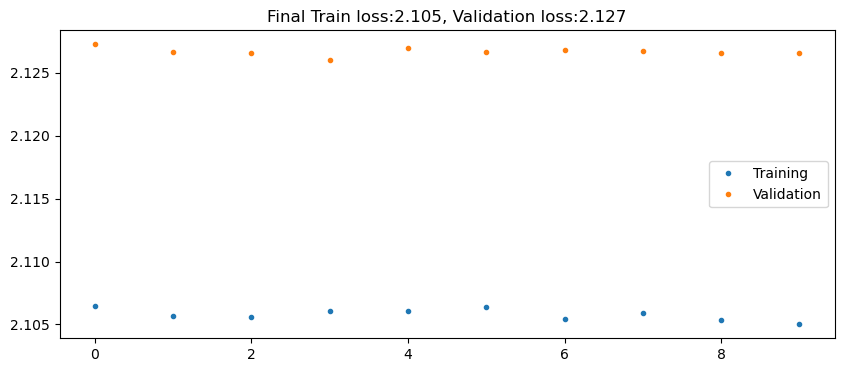

In [9]:
fig = plt.figure(figsize=(10, 4))
plt.plot(trnlossi, '.', label="Training")
plt.plot(vallossi, '.', label="Validation")
plt.title(f"Final Train loss:{trnloss[-1]:.3f}, Validation loss:{valloss[-1]:.3f}")
plt.legend()
plt.show()

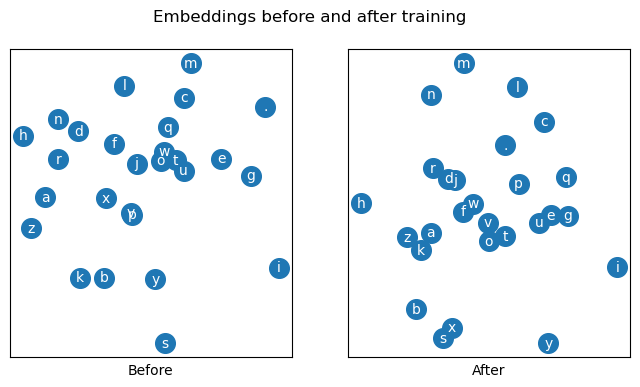

In [10]:
#Visualize embeddings before and after training
#Based on the training dataset, the model has arrived at character affinity.
#i.e. Characters that are semantically similar are closer to each other e.g. vowels
#If we rerun the model, characters affinity will be different. 
#DL models are indeterministic,
#Randomization of model weights&biases or data(due to shuffle or different data) leads of different models every time

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(Cinit[:,0].data, Cinit[:,1].data, s=200)
ax[1].scatter(C[:,0].data, C[:,1].data, s=200)
ax[0].set_xlabel("Before")
ax[1].set_xlabel("After")
for i in range(C.shape[0]):
    ax[0].text(Cinit[i,0].item(), Cinit[i,1].item(), itos[i], ha="center", va="center", color="white")
    ax[1].text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
for i in range(2):
    ax[i].set_xticks(())
    ax[i].set_yticks(())

fig.suptitle("Embeddings before and after training")
plt.show()

In [11]:
# Final test loss
mdl.eval()
with torch.no_grad():
    emb = C[tst_d]
    yH = mdl(emb.view(-1, blk_sz*emb_sz))
loss = lossfn(yH, tst_l)
print(f"Final Test loss: {loss}")

Final Test loss: 2.1100080013275146


In [12]:
# Generate random names based on prompt
# Not the best though
# Below shows a few generated names starting with 'c'

prompt = 'c'
for i in range(10):
    context = [0]*blk_sz
    firstchar = stoi.get(prompt)
    while True:
        emb = C[torch.tensor([context])]
        p = mdl(emb.view(-1, blk_sz*emb_sz))
        if prompt and firstchar:
            ix = firstchar
            firstchar = ''
        else:
            ix = torch.multinomial(F.softmax(p, 1), num_samples=1, generator=sd).item()
        context = context[1:] + [ix]
        if ix == 0:
            print()
            break
        else:
            print(itos[ix], end='')

cchrishan
came
cadeeman
cayskak
chareya
calyi
cori
cataelee
coatelynn
castia
